Import libraries

In [18]:
import random
from numpy import pi
import numpy as np
from IPython.display import Image
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Batch
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSamplerV2
from qiskit import transpile
import math
from qiskit.visualization import plot_bloch_multivector

In the early 1900s, experiments such as blackbody radiation and the Stern-Gerlach experiment showed that certain atomic properties are quantized, motivating a quantum theory of matter. The Bohr-Sommerfeld model treated electrons as moving in discrete orbits with quantized angular momentum and, although incomplete, it explained discrete spectral lines.

It is this orbital angular momentum that Stern and Gerlach wanted to observe in their experiment. Quantized angular momentum implies a quantized magnetic moment. Classically, a particle of charge $q$, mass $m$ and orbital angular momentum $\vec{L}$ has
$$
\vec{\mu} = \frac{q}{2m}\vec{L}.
$$

In quantum mechanics this becomes
$$
\vec{\mu} = g\frac{q}{2m}\vec{J},
$$
where $\vec{J}$ is the angular momentum and $g$ is a numerical ratio related to the type of angular momentum. If $J$ is quantized, then $\mu$ is quantized.

In a magnetic field
$$
\vec{\tau} = \vec{\mu} \times \vec{B}, \qquad
\vec{F} = \nabla(\vec{\mu} \cdot \vec{B}),
$$
so along $z$
$$
F_z = \mu_z \frac{dB_z}{dz} = g\frac{q}{2m} J_z \frac{dB_z}{dz}.
$$

In the Stern-Gerlach setup, a beam of neutral silver atoms passes through an inhomogeneous magnetic field. Classically a continuous distribution of deflections from randomly oriented magnetic moments is expected, but experimentally the beam splits into discrete spots, demonstrating quantized angular momentum. So not only is the angular momentum of the electron quantized, so is the projection along a chosen axis ($z$ here).

The lab now runs this experiment on real quantum hardware.

## A single measurement

Initialize a random spin state, like a random neutral silver atom.

In [4]:
a = random.random()
b = random.random()
norm = np.sqrt(a * np.conjugate(a) + b * np.conjugate(b))
a = a / norm
b = b / norm
print(a, b)

0.8199470050847703 0.5724394368424626


Map this state onto a quantum circuit, and measure.

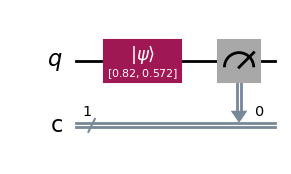

In [5]:
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the quantum state
qc.initialize([a, b])
qc.measure(0, 0)
qc.draw("mpl")

# this is similar to using,
#qc = QuantumCircuit(1)
#qc.initialize([a, b])
#qc.measure_all()
# however we are explicitly naming classical register here, which is used later on.

In [6]:
 # Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the quantum state
qc.initialize([a, b])
qc.measure(0, 0)
qc.draw("mpl")
fig = qc.draw("mpl")
fig.axes[0].set_title("Map classical spin orientation to a quantum state")
fig.savefig("qc_circuit.png")  
plt.show()

The next steps optimize the problem for quantum hardware execution, these steps are explained in more detail in the 'Quantum Coins and Superposition' notebook.

In [27]:
service = QiskitRuntimeService(name="oxford")

management.get:WARNING:2025-11-08 16:15:26,576: Loading saved account: oxford


In [28]:
# Use the least busy backend, specify options as needed
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
backend = service.least_busy()
print(backend.name)

ibm_torino


In [9]:
# Transpile the circuit and optimize for running on the quantum computer selected
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
qc_ibm = pm.run(qc)

Open users cannot run sessions. With no session, each sampler call is queued independently (can be run multiple times in sessions), but multiple outcomes can still be obtained by increasing shots. Session is not actually useful here other than best practice generalizing for cases where multiple sampler runs required

In [10]:
# Specify that we want to use only a single shot, to represent a single measurement of a spin in a SG device.
num_shots = 1
 
 
#Open users can still carry out this experiment, but without making use of a session, meaning repeated queuing is possible.
batch = Batch(backend=backend) #groups multiple run calls into one job
sampler = Sampler(mode=batch)
dist = sampler.run([qc_ibm], shots=num_shots).result()
#Close the batch because no context manager was used.
batch.close() #manually end and submit
counts = dist[0].data.c.get_counts()

counts =  {'0': 1}


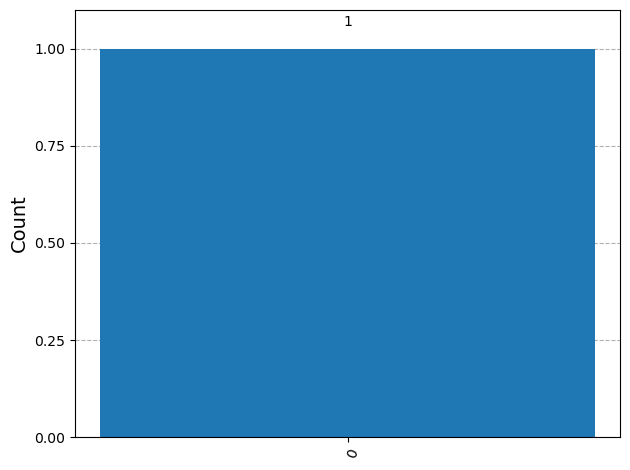

In [11]:
print("counts = ", counts)
plot_histogram(counts)

This result would have been surprising as a continuous spread of outcomes between 0 and 1 were expected, not a discrete result. A single result of “0” alone doesn't say much, since in both pictures it is still one possible outcome.

Saving plots with title optional, but completed in case the plots are needed at a later stage.

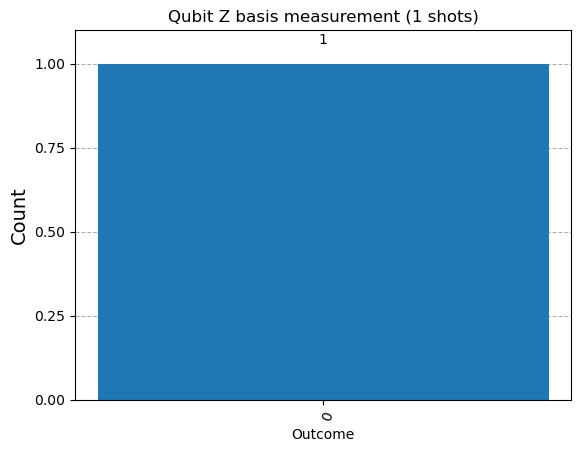

In [12]:
fig, ax = plt.subplots()
plot_histogram(counts, sort='asc', ax=ax)

ax.set_xlabel("Outcome")
ax.set_ylabel("Count")
ax.set_title(f"Qubit Z basis measurement ({num_shots} shots)")
fig.savefig("qubit_histogram(1).png")
plt.show()

## Measuring many particles

In [13]:
num_shots = 100
 
 
#Open users can still carry out this experiment, but without making use of a session, meaning repeated queuing is possible.
batch = Batch(backend=backend)
sampler = Sampler(mode=batch)
dist = sampler.run([qc_ibm], shots=num_shots).result()
#Close the batch because no context manager was used.
batch.close()
counts = dist[0].data.c.get_counts()

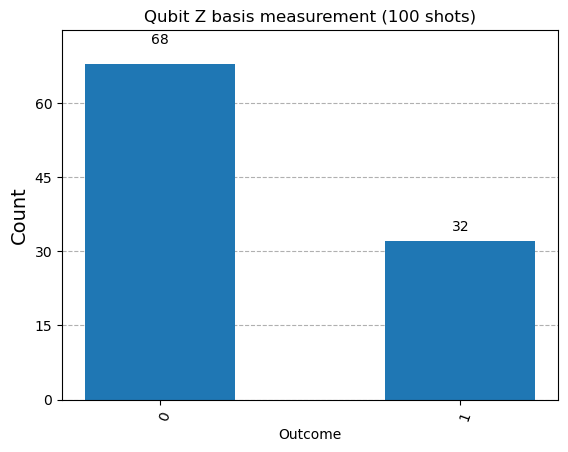

In [14]:
fig, ax = plt.subplots()
plot_histogram(counts, sort='asc', ax=ax)

ax.set_xlabel("Outcome")
ax.set_ylabel("Count")
ax.set_title(f"Qubit Z basis measurement ({num_shots} shots)")
fig.savefig("qubit_histogram.png")
plt.show()

Measure 0 or 1, with probabilities $P(0)=|a|^2=|0.8199470050847703|^2\approx0.67, P(1)=|b|^2=|0.5724394368424626|^2\approx0.33$, and no inbetween. This would have been very surprising, as even though the state is some superposition of the two, it only measures a discrete result, with probabilities determined by the coefficients.

## Random spins in an oven

More analogous to the actual Stern–Gerlach experiment is to consider many particles with random spin orientations and measuring each one.


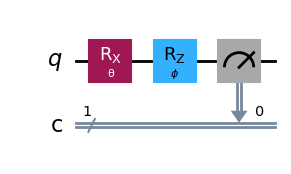

In [45]:
# from qiskit.circuit import QuantumCircuit, Parameter
 
theta = Parameter("θ")
phi = Parameter("$\phi$")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Add rotation gates for rotating the state of qubit 0 to random orientations
qc.rx(theta, 0)
qc.rz(phi, 0)
qc.measure(0, 0)
 
qc.draw("mpl")

In [46]:
fig = qc.draw("mpl")
fig.axes[0].set_title(r"Rotate a qubit to an arbitrary spin orientation with $R_x(\theta)$ and $R_z(\phi)$, then measure")
fig.savefig("qc_spin_circuit.png")  
plt.show()

In [47]:
# This uses a local simulator
# This generates a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)
sampler_sim = BackendSamplerV2(backend=backend_sim)
 

This type of experiment is exactly what running a session would be useful for, rather than running queued samplers. For simplicity a local simulator is used.

In [48]:
# A list to store the accumulated probabilities of the two possible measurement outcomes.
probslist = {"0": 0.0, "1": 0.0}
 
# Choose how many "particles"/measurements
measurements = 100
num_shots = 1
 
for i in range(measurements):
    # Assign a random orientation for each measurement
    phi = random.random() * 2 * pi
    theta = random.random() * 2 * pi
 
    angles = [phi, theta] #??? mistake in IBM code
    circuit = qc.assign_parameters(angles)
    qc_ibm = pm.run(circuit)
 
    # Run the circuit
    # job = sampler.run([circuit],num_shots = 1)
    dist = sampler_sim.run([qc_ibm], shots=num_shots).result()
 
    # Update the list of probabilities
    zeroterm = dist[0].data.c.get_counts().get("0") or 0
    oneterm = dist[0].data.c.get_counts().get("1") or 0
    probslist.update({"0": probslist.get("0") + zeroterm})
    probslist.update({"1": probslist.get("1") + oneterm})
 
probslist.update({"0": probslist.get("0") / measurements})
probslist.update({"1": probslist.get("1") / measurements})
# print(probslist)

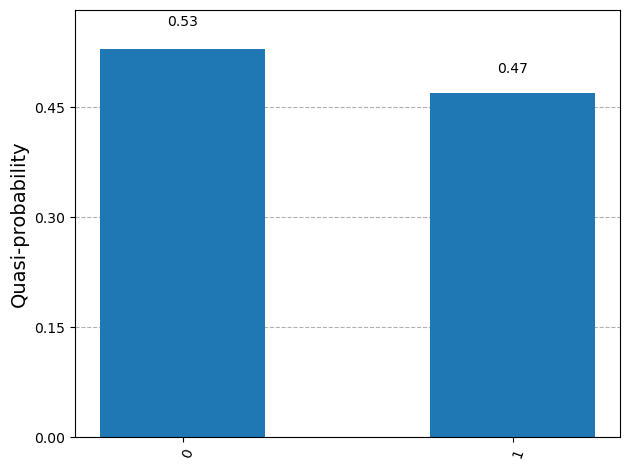

In [49]:
plot_histogram(probslist)

As seen experimentally, even with a set of random initial states, the measurements will only yield measurements of 0 or 1, confirming spin quantization along the chosen axis. The statistics here are different to the repeated measurements in the last part, showing the statistics of that state, as we are doing only one measurement of each individual state for a set of random states, which is why we see more evenly distributed quasi-probabilities here.

## Repeated measurements

The next part of the experiment explores what happens if we measure twice in a row, to see whether the first measurement influences the second. Applying a Hadamard gate to $|0\rangle$ creates the superposition $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$. The question is, if the first measurement gives $|0\rangle$, does the second measurement give $|0\rangle$ or $|1\rangle$ with equal probability? 

With knowledge of quantum mechanics, it is obvious that the state collapses into the state $|0\rangle$, but from the 'Measuring many particles' experiment, it would be logical (but incorrect), to think that the second measurement would give $|0\rangle$ with $P(0)=|\frac{1}{\sqrt{2}}|^2=\frac{1}{2}$, and $|1\rangle$ with $P(1)=\frac{1}{2}$.

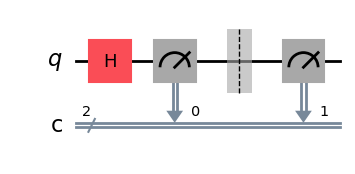

In [96]:
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the qubit to be a mixture of 0 and 1 states.
qc.h(0)
 
# Add a first measurement
qc.measure(0, 0)
qc.barrier()
 
# Add a second measurement
qc.measure(0, 1)
 
qc.draw("mpl")
 

In [97]:
fig = qc.draw("mpl")
fig.axes[0].set_title(r"Hadamard gate brings state $|0\rangle$ into an equal superposition of $|0\rangle$ and $|1\rangle$, then measure twice")
fig.savefig("qc_double_circuit.png")  
plt.show()

In [57]:
qc_ibm = pm.run(qc)

In [60]:
# Step 3: Run the job
 
num_shots = 1000
#dist = sampler.run([qc_ibm], shots=num_shots).result()
# To run on a simulator, uncomment the line below and comment out the line above.
dist = sampler_sim.run([qc_ibm], shots=num_shots).result()
counts = dist[0].data.c.get_counts()
print(counts)

{'00': 489, '11': 504, '01': 6, '10': 1}


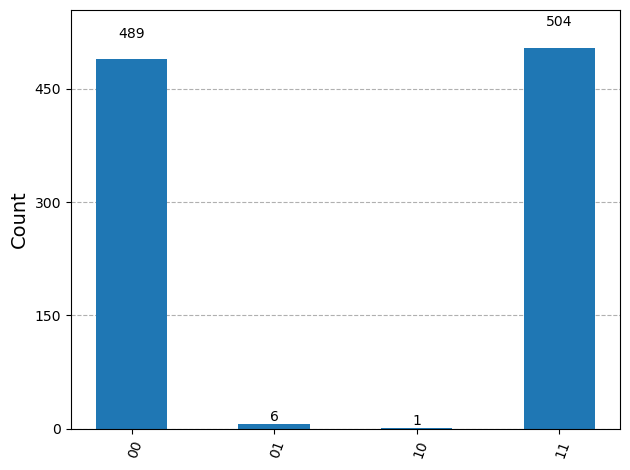

In [61]:
# Step 4: Post-process
plot_histogram(counts)

01 means the first measurement gave $|1\rangle$, and the second gave $|0\rangle$. 

As expected with knowledge of quantum mechanics, the first measurement collapses the state, and all subsequent measurements (up to small noise effects), will give that state.

The outcomes here motivate the mathematical description of quantum mechanics, where measurement is represented by an operator whose eigenvalues are the possible outcomes, and whose eigenvectors are the states left unchanged (up to a phase). For spin along $z$, $|0\rangle=\left(1,0\right)^T$ and $|1\rangle=\left(0,1\right)^T$ are eigenstates of the $Z= \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$ operator, which is why once you measure one of them, repeating the measurement along $z$ keeps giving the same result.

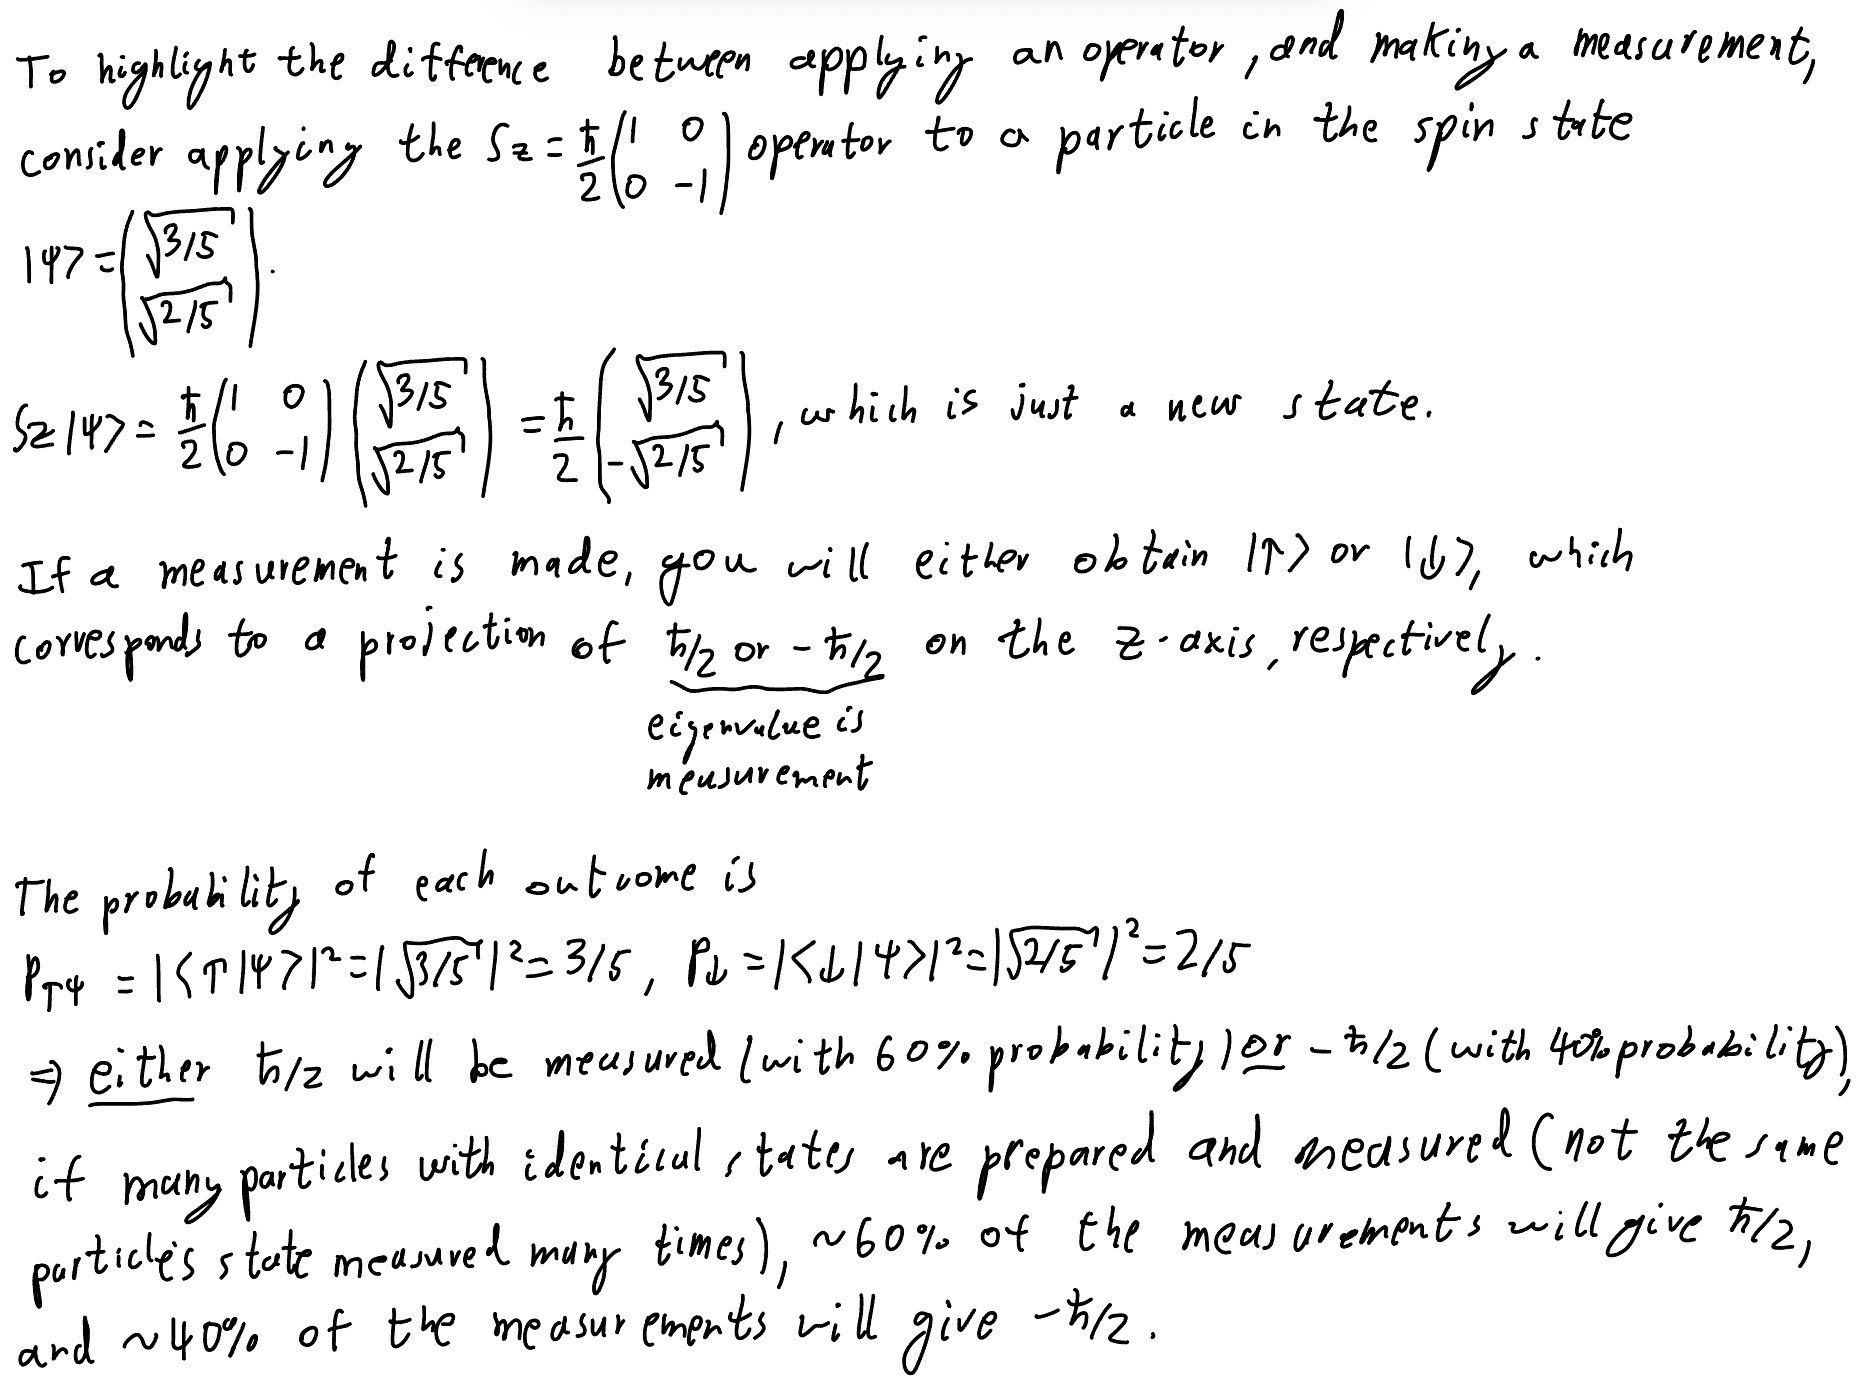

In [19]:
Image('Operator_v_measurement.jpeg',width=1000)

To verify what's written, first make a single measurement

In [22]:
backend_sim = AerSimulator.from_backend(backend)
sampler = BackendSamplerV2(backend = backend_sim)

psi = [math.sqrt(3/5),math.sqrt(2/5)]
qc = QuantumCircuit(1,1)
qc.initialize(psi, [0])

#Add measurement to the circuit
qc.measure(0,0)
qc.draw('mpl')

#Set num_shots =1 for part (b) and num_shots = 1000 or more for part (c).
num_shots = 1

#Run the job and print the result. You should obtain only 0 or 1 in part (b) for a single shot.
#You should obtain a probability distribution with approximately 60% 0 and 40% 1 in part (c)

dist = sampler.run([qc_ibm], shots = num_shots).result()
counts=dist[0].data.c.get_counts()
print(counts)

#You should obtain {0: 599, 1: 401} or something equivalently close to the 60%-40% distribution predicted.


{'0': 1}


The result of the single measurement is 0 (collapsing to the state $\left(1,0\right)^T$), not a superposition of 0 and 1, somehow collapsing to the superposition state $\left(\sqrt{3/5},\sqrt{2/5}\right)^T$.

In [23]:
#Set num_shots =1 for part (b) and num_shots = 1000 or more for part (c).
num_shots = 1000

#Run the job and print the result. You should obtain only 0 or 1 in part (b) for a single shot.
#You should obtain a probability distribution with approximately 60% 0 and 40% 1 in part (c)

dist = sampler.run([qc_ibm], shots = num_shots).result()
counts=dist[0].data.c.get_counts()
print(counts)

#You should obtain {0: 599, 1: 401} or something equivalently close to the 60%-40% distribution predicted.


{'0': 684, '1': 316}


The result of each single measurement is 0 or 1, and the distribution of results is 0 ~ 60% of the time, and 1 ~ 40% of the time, as expected.

## Measuring different observables

IBM quantum computers only make measurements along the $z$ axis, so to measure along $x$ requires a change of basis.

From the 'Quantum Coins and Superposition' lab, it was found that:
$$
H|0\rangle= \frac{|0\rangle + |1\rangle}{\sqrt{2}}=|+\rangle_x,\text{  }H|1\rangle =\frac{|0\rangle - |1\rangle}{\sqrt{2}}=|-\rangle_x\text{ and }H^2=I
$$

So it follows that $H|+\rangle_x=|0\rangle$, and $H|-\rangle_x=|1\rangle$

It was also found that $HZH=X$, and $HXH=Z$, so the Hadamard gate effectively swaps $z$ and $x$ axes.

For a state initially in $|0\rangle$, what are the measurement statistics along $x$?

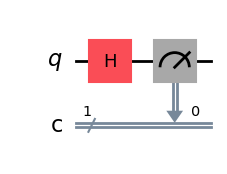

In [30]:
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Add a hadamard gate to rotate into the x-basis
qc.h(0)
qc.measure(0, 0)
 
qc.draw("mpl")

In [35]:
sampler_sv = Sampler()
 
job = sampler_sv.run([qc], shots=10000)
print(job.result()[0].data.c.get_counts())


{'1': 4965, '0': 5035}


The probability of measuring a projection along $+x$ or $-x$ is about 50-50. This makes sense since $|0\rangle = \frac{1}{\sqrt{2}}\left(|+\rangle + |-\rangle\right).$

For a state initially in $|1\rangle$, what are the measurement statistics along $x$?

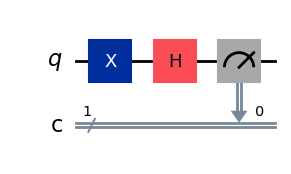

In [36]:
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Add a NOT gate and hadamard gate. Measure.
qc.x(0)
qc.h(0)
qc.measure(0, 0)
 
qc.draw("mpl")

In [91]:
fig = qc.draw("mpl")
fig.axes[0].set_title(r"NOT gate brings state $|0\rangle$ into $|1\rangle$, Hadamard gate brings $|1\rangle$ into $\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$, then measure")
fig.savefig("qc_NOT_Hadamard_circuit.png")  
plt.show()

In [92]:
job = sampler_sv.run([qc], shots=10000)
print(job.result()[0].data.c.get_counts())

{'0': 4998, '1': 5002}


The probability of measuring a projection along $+x$ or $-x$ is also about 50-50. This makes sense since $|1\rangle = \frac{1}{\sqrt{2}}\left(|+\rangle - |-\rangle\right).$

Viewing the transformations on the bloch sphere make these outcomes clear. The bloch vector has the same projection along $+z$ and $-z$, so when measuring in the $z$ basis, there should be even chance of measuring 0 and 1.

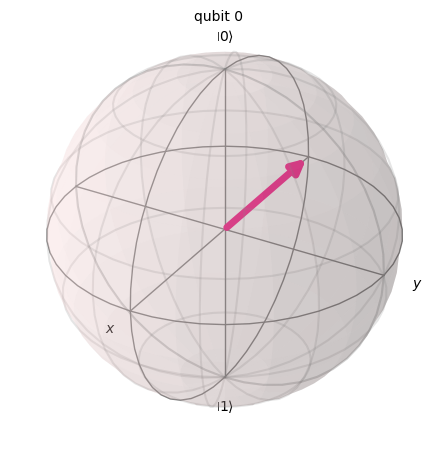

In [38]:
qview = QuantumCircuit(1)
qview.x(0)
 
qview.h(0)
plot_bloch_multivector(qview)

Does the state collapse seen earlier remain when both the first and second measurement are in the $x$ basis?

With knowledge of quantum mechanics, similar behaviour is expected, but now the state will collapse in $|+\rangle_x$ (since the state is initialized in $|0\rangle$), and the second measurement will give the same $|+\rangle_x$.

Something to note, if the first measurement is in $x$, a subsequent measurement in $z$ will give $|0\rangle$ or $|1\rangle$ with equal probability, since $|+\rangle_x=\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$. This means that a collapse in the $x$ basis does not fix outcomes in other bases.

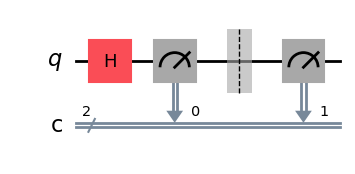

In [39]:
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
 
# Rotate into x-basis using a Hadamard gate, then make two measurements in succession
qc.h(0)
qc.measure(0, 0)
qc.barrier()
qc.measure(0, 1)
 
qc.draw("mpl")

{'00': 513, '11': 511}


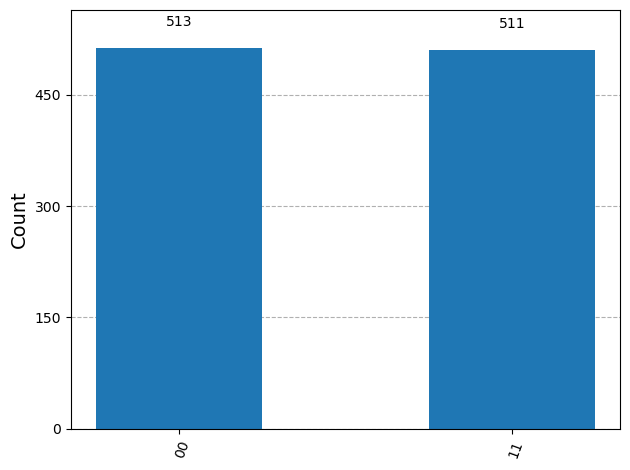

In [94]:
job = sampler_sv.run([qc])
print(job.result()[0].data.c.get_counts())
plot_histogram(job.result()[0].data.c.get_counts())

As expected, if the first measurement produces '0', the state collapses into $|0\rangle$, and any subsequent measurements (in the same basis) will give '0', and similarly, if the first measurement produces '1', all subsequent measurements will give '1'.

One thing to note is that a statevector sampler was used here, which gives ideal, noiseless probabilities from the statevector, unlike a real backend sampler on actual hardware that includes noise. The statevector sampler is noiseless, so we never see ‘01’ or ‘10’ if their ideal probability is zero. Any slight imbalance between ‘00’ and ‘11’ is due to finite sampling and will shrink as we take more shots.

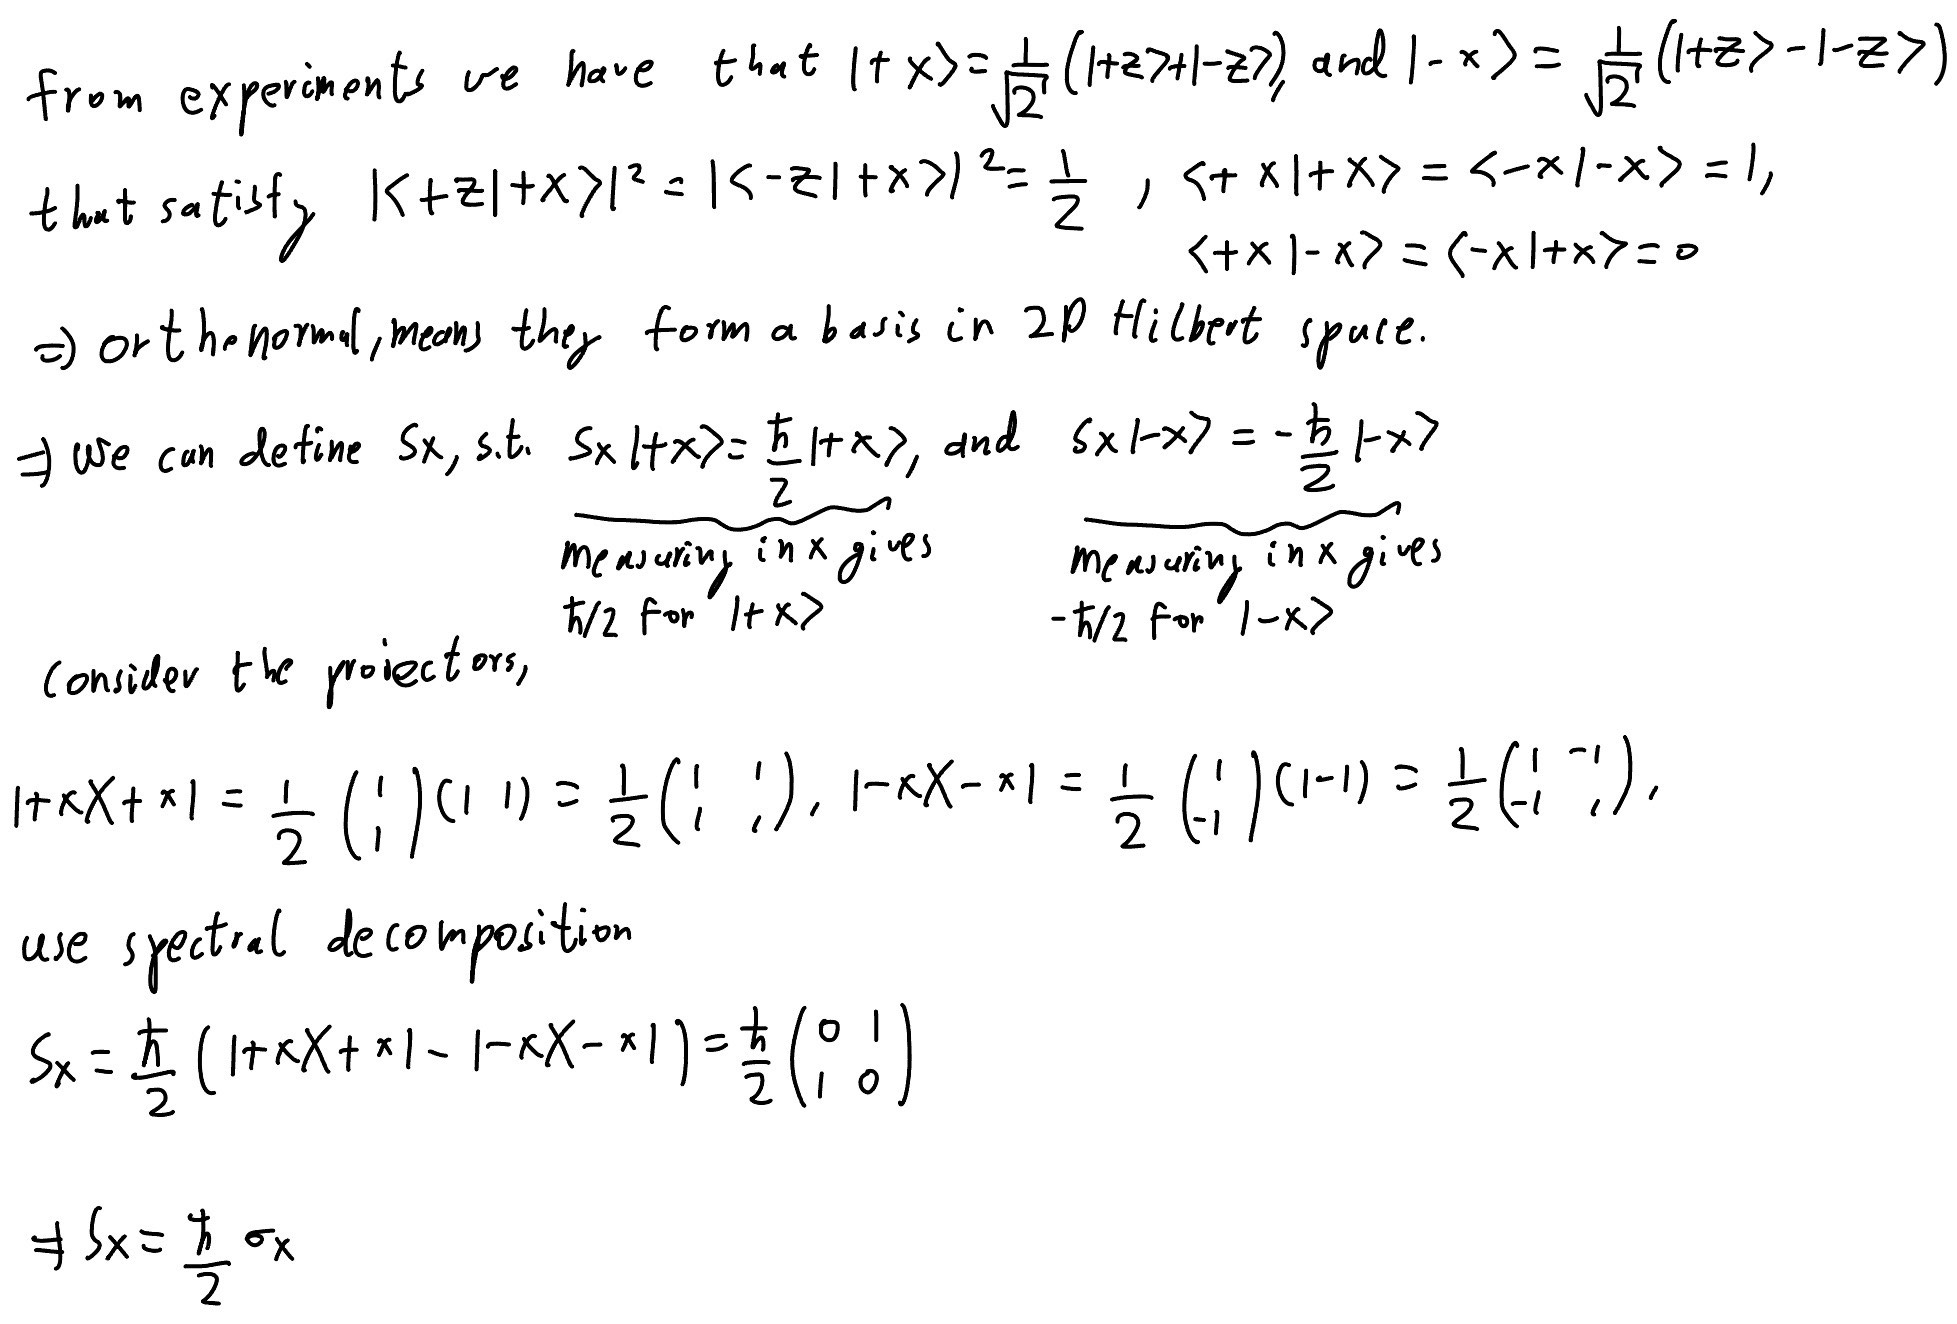

In [40]:
Image('S_x.jpeg',width=1000)

## Questions

**True/False Questions**

1. *Starting from experimental observations, the only valid choice for a vector to represent* $|\uparrow\rangle$ *is* $\left(1,0\right)^T$

**False**, this is just a convenient convention, any orthonormal basis would work.

2. *If* $|\uparrow\rangle=\left(1,0\right)^T,$ *the only choice for* $|\downarrow\rangle$ *is* $\left(0,1\right)^T$ *(up to a global phase).*

**True**, as they need to be orthonormal, for some $|\downarrow\rangle=\left(a,b\right)^T$, we require $\langle\downarrow|\uparrow\rangle=a=0$, and $\langle\downarrow|\downarrow\rangle=b^2=1\Rightarrow b=e^{i\phi}$, which means $|\downarrow\rangle=\left(0,e^{i\phi}\right)^T$, which up to a global phase is equivalent to $\left(0,1\right)^T$.

3. *A particle measured to be in the state* $|0\rangle$ *will continue to be found in the state* $|0\rangle$ *upon subsequent measurements along* $z$.

**True**, since $|0\rangle$ is an eigenstate of the $Z$ operator.

4. *A particle measured to be in the state* $|0\rangle$ *will continue to be found in the state* $|0\rangle$ *upon subsequent measurements along* $x$.

**False**, $|0\rangle$ is an eigenstate of $Z$, not $X$, so nothing is fixed in $x$, so a measurement along $x$ will give $|+x\rangle$ or $|-x\rangle$ with equal probability

5. *A particle measured to be in the state* $|0\rangle$ *will always be found in the state* $|+\rangle_x$ *upon subsequent measurements along* $x$.

**False**, $|0\rangle= \frac{|+x\rangle + |-x\rangle}{\sqrt{2}}$, so a measurement along $x$ gives $|+x\rangle$ or $|-x\rangle$ with probability 1/2 each, not always $|+x\rangle$.

**Multiple Choice Questions**

1. *A particle initially in* $|\uparrow\rangle$ *has what probability of being measured in the state* $|+x\rangle$ *?*

*a. 0%*

*b. 25%*

*c. 50%*

*d. 71%*

*e. 100%*

If $|\uparrow\rangle=|0\rangle$, then **c**, since $|0\rangle= \frac{|+x\rangle + |-x\rangle}{\sqrt{2}}$

2. *A particle initially in* $|\uparrow\rangle$ *has what probability of being measured in the state* $|\downarrow\rangle$ *?*

*a. 0%*

*b. 25%*

*c. 50%*

*d. 71%*

*e. 100%*

**a**, since they are orthonormal eigenstates, so $P(\downarrow | \uparrow) = |\langle \downarrow | \uparrow \rangle|^2 = 0.$

3. The state $|\uparrow\rangle$ of a spin-1/2 particle is most commonly associated with what quantum computing state?

*a. $|+\rangle$*

*b. $|-\rangle$*

*c. $|0\rangle$*

*d. $|1\rangle$* 

*e. None of the above*

**c**

**Discussion questions**

1.*Three friends are discussing quantum measurements and operators. Friend A says, "Making a measurement along* $z$ *and acting with the operator* $\sigma_z$ *are the same thing." Friend B says, "Well, they are different procedures, but they have the same result." Friend C says, "They are totally different; they even have different effects on most states." With whom do you agree and why?*

I agree with **Friend C**.

A measurement in the $z$ basis is non-unitary (not reversible) and probabilistic. It projects the quantum state onto one of the eigenstates $|0\rangle$ or $|1\rangle$ and destroys superposition in that basis. For example, measuring $\frac{1}{\sqrt2}(|0\rangle+|1\rangle)$ gives $|0\rangle$ or $|1\rangle$ with equal probability 1/2.

The operator is a unitary and deterministic transformation. It changes the relative phase between the components but never collapses the state. For example $\sigma_z\frac{1}{\sqrt2}(|0\rangle+|1\rangle)=\frac{1}{\sqrt2}(|0\rangle-|1\rangle)$.  
  

Therefore, while the eigenvalues of $\sigma_z$ correspond to possible measurement outcomes,  
the actions are fundamentally different.

**Free response problems**

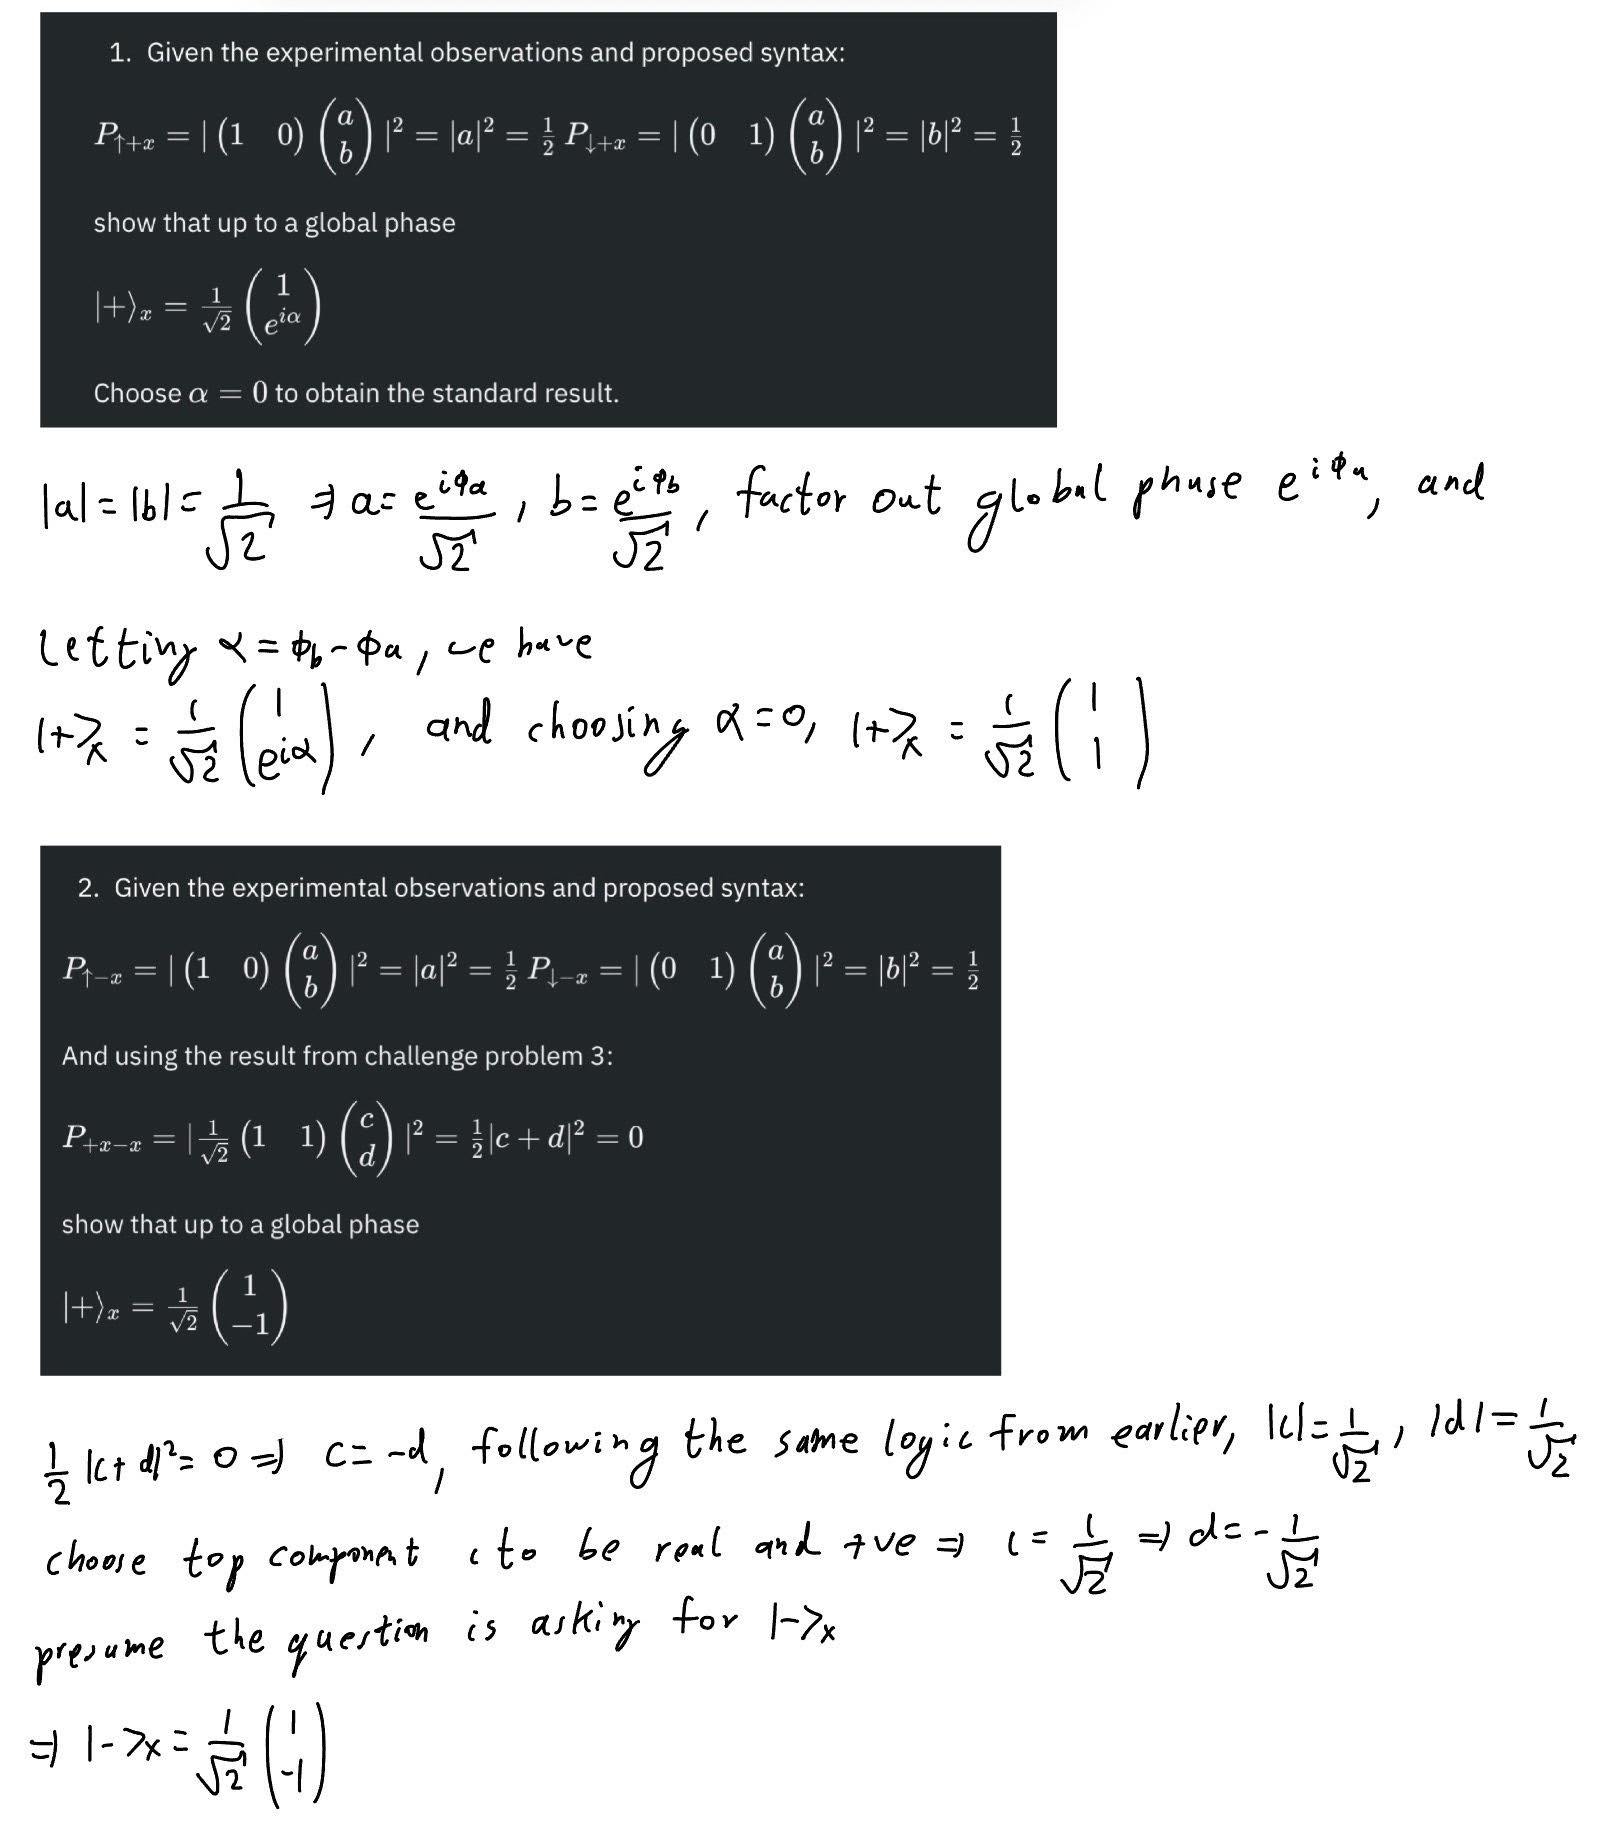

In [41]:
Image('Free_response.jpg',width=1000)